# Supervised Contrastive Learning

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2020/11/30<br>
**Last modified:** 2020/11/30<br>
**Description:** Using supervised contrastive learning for image classification.

## Introduction

[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
(Prannay Khosla et al.) is a training methodology that outperforms
supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive
Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

Note that this example requires [TensorFlow Addons](https://www.tensorflow.org/addons), which you can install using the following command:

```python
pip install tensorflow-addons
```

## Setup

In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.1 MB/s 


In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the data

CIFAR10 데이터셋을 사용한다.  
클래스 수는 10개이며, 32 by 32 pixels의 3채널을 갖는 컬러이미지 데이터셋이다. 

In [4]:
num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


170508288/170498071 [==============================] - 14s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


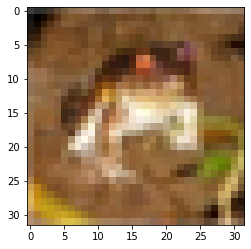

In [13]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

## Using image data augmentation

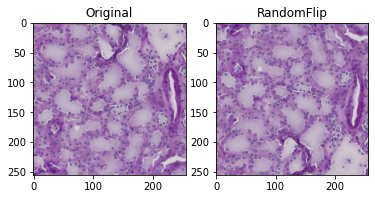

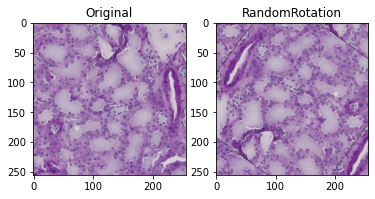

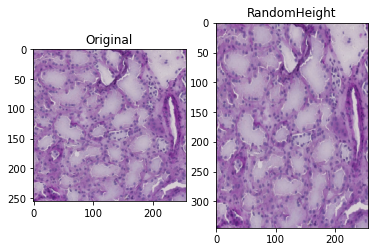

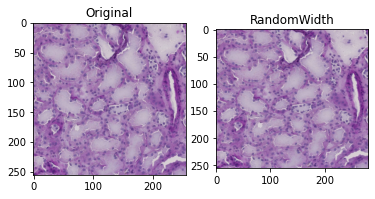

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),#랜덤으로 가로로 뒤집어줌.
        layers.RandomRotation(0.02),#랜덤으로 0.02만큼 Rotation을 수행해줌.
        layers.RandomWidth(0.2),#width를 0.2만큼 늘려준다.
        layers.RandomHeight(0.2),#Height를 0.2만큼 늘려준다. 
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

## Build the encoder model

The encoder model takes the image as input and turns it into a 2048-dimensional
feature vector.

In [6]:

def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23,564,807
Trainable params: 23,519,360
Non-trainable params: 45,447
_________________________________________________________________


## Build the classification model

The classification model adds a fully-connected layer on top of the encoder,
plus a softmax layer with the target classes.

In [7]:

def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


## Experiment 1: Train the baseline classification model

In this experiment, a baseline classifier is trained as usual, i.e., the
encoder and the classifier parts are trained together as a single model
to minimize the crossentropy loss.

In [8]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")


Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                

## Experiment 2: Use supervised contrastive learning

In this experiment, the model is trained in two phases. In the first phase,
the encoder is pretrained to optimize the supervised contrastive loss,
described in [Prannay Khosla et al.](https://arxiv.org/abs/2004.11362).

In the second phase, the classifier is trained using the trained encoder with
its weights freezed; only the weights of fully-connected layers with the
softmax are optimized.

### 1. Supervised contrastive learning loss function

In [9]:

class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model


### 2. Pretrain the encoder

In [10]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23,827,079
Trainable params: 23,781,632
Non-trainable params: 45,447
_________________________________________________________________
Epoch 1/50
189/189 [==============================] - 27s 118ms/step - loss: 5.3615
Epoch 2/50
189/189 [==============================] - 22s 118ms/step - loss: 5.1494
Epoch 3/50
189/189 [=========================

### 3. Train the classifier with the frozen encoder

In [11]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/50
189/189 [==============================] - 10s 35ms/step - loss: 0.3588 - sparse_categorical_accuracy: 0.9021
Epoch 2/50
189/189 [==============================] - 7s 36ms/step - loss: 0.3173 - sparse_categorical_accuracy: 0.9048
Epoch 3/50
189/189 [==============================] - 7s 35ms/step - loss: 0.2963 - sparse_categorical_accuracy: 0.9097
Epoch 4/50
189/189 [==============================] - 7s 36ms/step - loss: 0.2894 - sparse_categorical_accuracy: 0.9112
Epoch 5/50
189/189 [==============================] - 7s 36ms/step - loss: 0.2951 - sparse_categorical_accuracy: 0.9089
Epoch 6/50
189/189 [==============================] - 7s 36ms/step - loss: 0.2839 - sparse_categorical_accuracy: 0.9121
Epoch 7/50
189/189 [==============================] - 7s 36ms/step - loss: 0.2839 - sparse_categorical_accuracy: 0.9122
Epoch 8/50
189/189 [==============================] - 7s 35ms/step - loss: 0.2912 - sparse_categorical_accuracy: 0.9092
Epoch 9/50
189/189 [===================

We get to an improved test accuracy.

## Conclusion

As shown in the experiments, using the supervised contrastive learning technique
outperformed the conventional technique in terms of the test accuracy. Note that
the same training budget (i.e., number of epochs) was given to each technique.
Supervised contrastive learning pays off when the encoder involves a complex
architecture, like ResNet, and multi-class problems with many labels.
In addition, large batch sizes and multi-layer projection heads
improve its effectiveness. See the [Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
paper for more details.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/supervised-contrastive-learning-cifar10) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/supervised-contrastive-learning).